# Notebook 4: Modeling & Results

![Is It Worth the Time?](../media/is_it_worth_the_time_2x.png)

**Phases 8-9:** Modeling, Results & Insights

**Dataset:** NYC Taxi Trip Dataset (continuing from Notebook 3)

**Focus:** Building predictive models, evaluating performance, interpreting results, and communicating insights.

---

**Where we are:** We've cleaned our data (Notebook 1), created features (Notebook 2), and prepared for modeling (Notebook 3). Now we build and evaluate predictive models.

**What we'll accomplish:**
- Train multiple model types (Linear Regression, Random Forest, XGBoost)
- Evaluate and compare model performance
- Interpret feature importance
- Communicate results effectively

**Why this matters:** 
- Different models make different assumptions - comparing them helps us understand our data
- Performance metrics tell us if our model is useful in practice
- Feature importance helps us understand what drives predictions

**The big picture:**
- **Notebook 1:** Made data clean ✓
- **Notebook 2:** Made data useful ✓
- **Notebook 3:** Made data ready for modeling ✓
- **Notebook 4 (this one):** Build and evaluate models

---

## Phase 8: Modeling

**Why we train multiple models:** Different algorithms make different assumptions about the data:
- **Linear Regression:** Assumes relationships are linear (fare = a × distance + b)
- **Random Forest:** Can capture non-linear relationships and interactions
- **XGBoost:** Gradient boosting that learns complex patterns

**Our strategy:** Start simple (Linear Regression) as a baseline, then try more complex models. If complex models don't perform much better, the simple model is probably sufficient (Occam's Razor).

**What we're looking for:**
- Does the model generalize? (train vs test performance)
- Which features matter most? (feature importance)
- Are predictions reasonable? (visual inspection)

### Learning Objectives

- Train multiple model types
- Evaluate model performance
- Compare models
- Interpret model results
- Identify overfitting

### Step 1: Load Prepared Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Modeling libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load prepared data from Notebook 3
X_train = pd.read_csv('../output/03_X_train.csv')
X_test = pd.read_csv('../output/03_X_test.csv')
y_train = pd.read_csv('../output/03_y_train.csv').squeeze()  # Convert to Series
y_test = pd.read_csv('../output/03_y_test.csv').squeeze()

display(Markdown(f"""
### 📂 Data Loaded

| Dataset | Shape |
|---------|-------|
| **Training set** | {X_train.shape[0]:,} × {X_train.shape[1]} |
| **Test set** | {X_test.shape[0]:,} × {X_test.shape[1]} |

**Features:** `{list(X_train.columns[:5])}...` ({len(X_train.columns)} total)
"""))


### 📂 Data Loaded

| Dataset | Shape |
|---------|-------|
| **Training set** | 2,303,523 × 21 |
| **Test set** | 575,881 × 21 |

**Features:** `['hour', 'day_of_week', 'month', 'is_weekend', 'trip_distance']...` (21 total)


**Understanding Model Metrics:**

Before we train models, let's understand what our evaluation metrics mean:

| Metric | What it Measures | Interpretation |
|--------|------------------|----------------|
| **RMSE** | Average prediction error (in dollars) | If RMSE = $3.50, predictions are off by $3.50 on average |
| **MAE** | Average absolute error | Similar to RMSE but less sensitive to outliers |
| **R²** | Proportion of variance explained | R² = 0.75 means model explains 75% of fare variability |

**What's a "good" R²?** It depends on the domain. For complex real-world problems, R² = 0.5 might be excellent. For simple relationships, R² < 0.9 might indicate missing features.

### ⚠️ Critical Check: Feature Leakage Before Modeling

Before training models, verify you haven't introduced **feature leakage** (using information from the target or future data to make predictions).

**Quick Leakage Checks:**

In [2]:
# Check 1: Are any features too highly correlated with target?
# High correlation (>0.95) suggests potential leakage
print("Correlation with target (fare_amount):")
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
suspicious = correlations[correlations > 0.95]
if len(suspicious) > 0:
    print(f"⚠️ WARNING: {len(suspicious)} features have correlation > 0.95 with target:")
    print(suspicious)
else:
    print("✅ No suspiciously high correlations")

# Check 2: Do any feature names suggest they depend on the target?
target_related = [col for col in X_train.columns if 'fare' in col.lower() or 'total' in col.lower()]
if target_related:
    print(f"\n⚠️ WARNING: Features with 'fare' or 'total' in name: {target_related}")
    print("Verify these don't leak target information!")
else:
    print("\n✅ No obviously problematic feature names")

Correlation with target (fare_amount):
⚠️ WARNING: 1 features have correlation > 0.95 with target:
trip_distance    0.95631
dtype: float64

⚠️ WARNING: Features with 'fare' or 'total' in name: ['fare_per_mile']
Verify these don't leak target information!


**Common leakage sources:**
- Features derived from the target variable (e.g., `tip_percentage = tip/fare` when predicting `fare`)
- Rolling windows that include future data
- Group statistics calculated on entire dataset (including test set)
- Information that wouldn't be available at prediction time

**If you find leakage:** Remove the leaky features from your training data before proceeding.

---

Let's define helper functions and constants for model evaluation:

In [3]:
# Model evaluation helper functions
def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    """
    Calculate standard regression metrics.

    Demonstrates DRY principle: evaluation logic in one place.

    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    dataset_name : str
        Name for display purposes

    Returns:
    --------
    dict : Dictionary containing RMSE, MAE, and R² scores
    """
    return {
        'dataset': dataset_name,
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

def assess_overfitting(train_r2, test_r2):
    """
    Assess model overfitting by comparing train and test R² scores.

    Overfitting gap = Train R² - Test R²
    - < 5%: Excellent generalization
    - 5-10%: Good generalization
    - 10-20%: Some overfitting - consider regularization
    - > 20%: Severe overfitting - model needs adjustment

    Parameters:
    -----------
    train_r2 : float
        R² score on training set
    test_r2 : float
        R² score on test set

    Returns:
    --------
    tuple : (gap, status_message)
    """
    gap = train_r2 - test_r2

    if gap < 0.05:
        return gap, "✅ Excellent generalization"
    elif gap < 0.10:
        return gap, "✅ Good generalization"
    elif gap < 0.20:
        return gap, "⚠️ Some overfitting - consider regularization"
    else:
        return gap, "❌ Severe overfitting - model needs adjustment"

# Model hyperparameters
RANDOM_SEED = 42  # For reproducible results

# Random Forest hyperparameters
RF_N_ESTIMATORS = 100  # Number of trees (more = better but slower)
RF_MAX_DEPTH = 10      # Max tree depth (lower = less overfitting)

# XGBoost hyperparameters
XGB_N_ESTIMATORS = 100    # Number of boosting rounds
XGB_MAX_DEPTH = 6         # Max tree depth (XGBoost default, shallower than RF)
XGB_LEARNING_RATE = 0.1   # Step size shrinkage (lower = more conservative)

**What is overfitting?**

Overfitting happens when a model memorizes training data instead of learning general patterns. It's like a student who memorizes answers to practice problems but fails the real exam.

**Signs of overfitting:**
- Train R² much higher than test R² (>20% gap)
- Model performs well on training data but poorly on new data
- Model is too complex for the amount of data

**How to fix:**
- Simplify the model (fewer features, shallower trees)
- Get more training data
- Use regularization (penalize complexity)

**🔬 Try This: Experiment with Hyperparameters**

The constants above make it easy to experiment! After training, try changing one at a time:
- `RF_MAX_DEPTH`: Lower (3) for simpler model, higher (20) for more complex
- `RF_N_ESTIMATORS`: More trees = better but slower
- `XGB_LEARNING_RATE`: Lower (0.01) for more conservative learning

### Step 2: Baseline Model - Linear Regression

In [4]:
# Train linear regression model
display(Markdown("# 📊 Model 1: Linear Regression"))

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate using helper function
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Training")
test_metrics_lr = evaluate_model(y_test, y_test_pred_lr, "Test")

# Check for overfitting using helper function
overfit_lr, overfit_status = assess_overfitting(train_metrics_lr['r2'], test_metrics_lr['r2'])

display(Markdown(f"""
### Performance Results

| Metric | Training | Test |
|--------|----------|------|
| **RMSE** | ${train_metrics_lr['rmse']:.2f} | ${test_metrics_lr['rmse']:.2f} |
| **MAE** | ${train_metrics_lr['mae']:.2f} | ${test_metrics_lr['mae']:.2f} |
| **R²** | {train_metrics_lr['r2']:.4f} | {test_metrics_lr['r2']:.4f} |

**Overfitting (R² difference):** {overfit_lr:.4f} — {overfit_status}
"""))

# Store for comparison later
train_rmse_lr, test_rmse_lr = train_metrics_lr['rmse'], test_metrics_lr['rmse']
train_r2_lr, test_r2_lr = train_metrics_lr['r2'], test_metrics_lr['r2']

# 📊 Model 1: Linear Regression


### Performance Results

| Metric | Training | Test |
|--------|----------|------|
| **RMSE** | $4.28 | $3.90 |
| **MAE** | $1.37 | $1.32 |
| **R²** | 0.9378 | 0.9421 |

**Overfitting (R² difference):** -0.0043 — ✅ Excellent generalization


### Step 3: Random Forest Model

In [5]:
# Train Random Forest model
display(Markdown("# 🌲 Model 2: Random Forest"))

rf_model = RandomForestRegressor(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    random_state=RANDOM_SEED,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate using helper function
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Training")
test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Test")

# Check for overfitting using helper function
overfit_rf, overfit_status = assess_overfitting(train_metrics_rf['r2'], test_metrics_rf['r2'])

display(Markdown(f"""
### Performance Results

| Metric | Training | Test |
|--------|----------|------|
| **RMSE** | ${train_metrics_rf['rmse']:.2f} | ${test_metrics_rf['rmse']:.2f} |
| **MAE** | ${train_metrics_rf['mae']:.2f} | ${test_metrics_rf['mae']:.2f} |
| **R²** | {train_metrics_rf['r2']:.4f} | {test_metrics_rf['r2']:.4f} |

**Overfitting (R² difference):** {overfit_rf:.4f} — {overfit_status}
"""))

# Store for comparison later
train_rmse_rf, test_rmse_rf = train_metrics_rf['rmse'], test_metrics_rf['rmse']
train_r2_rf, test_r2_rf = train_metrics_rf['r2'], test_metrics_rf['r2']

# 🌲 Model 2: Random Forest


### Performance Results

| Metric | Training | Test |
|--------|----------|------|
| **RMSE** | $0.98 | $0.98 |
| **MAE** | $0.48 | $0.49 |
| **R²** | 0.9967 | 0.9963 |

**Overfitting (R² difference):** 0.0004 — ✅ Excellent generalization


#### Random Forest Feature Importance

In [6]:
# Extract feature importance from the trained model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

display(Markdown("### 🔑 Top 10 Most Important Features"))
display(Markdown(feature_importance.head(10).to_markdown(index=False)))

### 🔑 Top 10 Most Important Features

| feature                  |   importance |
|:-------------------------|-------------:|
| trip_distance            |  0.913668    |
| fare_per_mile            |  0.051263    |
| trip_duration            |  0.0336454   |
| speed_mph                |  0.00118499  |
| hour                     |  6.60861e-05 |
| day_of_week              |  3.55581e-05 |
| distance_category_Medium |  2.37779e-05 |
| distance_category_Short  |  2.14252e-05 |
| pickup_borough_Manhattan |  1.87064e-05 |
| time_of_day_Night        |  1.69491e-05 |

**What is feature importance?**

Feature importance tells us which variables the model relies on most for predictions. For tree-based models (Random Forest, XGBoost), importance is calculated based on how much each feature reduces prediction error across all trees.

**How to interpret:**
- **High importance (>0.1):** Feature strongly influences predictions
- **Medium importance (0.01-0.1):** Feature contributes but isn't dominant
- **Low importance (<0.01):** Feature might be redundant or irrelevant

**Important caveat:** Importance doesn't tell us direction (positive or negative relationship) or causality. It just tells us what the model uses.

### Step 4: XGBoost Model

In [7]:
# Train XGBoost model
display(Markdown("# 🚀 Model 3: XGBoost"))

xgb_model = xgb.XGBRegressor(
    n_estimators=XGB_N_ESTIMATORS,
    max_depth=XGB_MAX_DEPTH,
    learning_rate=XGB_LEARNING_RATE,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate using helper function
train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Training")
test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test")

# Check for overfitting using helper function
overfit_xgb, overfit_status = assess_overfitting(train_metrics_xgb['r2'], test_metrics_xgb['r2'])

display(Markdown(f"""
### Performance Results

| Metric | Training | Test |
|--------|----------|------|
| **RMSE** | ${train_metrics_xgb['rmse']:.2f} | ${test_metrics_xgb['rmse']:.2f} |
| **MAE** | ${train_metrics_xgb['mae']:.2f} | ${test_metrics_xgb['mae']:.2f} |
| **R²** | {train_metrics_xgb['r2']:.4f} | {test_metrics_xgb['r2']:.4f} |

**Overfitting (R² difference):** {overfit_xgb:.4f} — {overfit_status}
"""))

# Store for comparison later
train_rmse_xgb, test_rmse_xgb = train_metrics_xgb['rmse'], test_metrics_xgb['rmse']
train_r2_xgb, test_r2_xgb = train_metrics_xgb['r2'], test_metrics_xgb['r2']

# 🚀 Model 3: XGBoost


### Performance Results

| Metric | Training | Test |
|--------|----------|------|
| **RMSE** | $1.76 | $1.56 |
| **MAE** | $0.36 | $0.36 |
| **R²** | 0.9895 | 0.9907 |

**Overfitting (R² difference):** -0.0012 — ✅ Excellent generalization


#### XGBoost Feature Importance

In [8]:
# Extract feature importance from the trained model
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

display(Markdown("### 🔑 Top 10 Most Important Features"))
display(Markdown(xgb_importance.head(10).to_markdown(index=False)))

### 🔑 Top 10 Most Important Features

| feature                     |   importance |
|:----------------------------|-------------:|
| trip_distance               |   0.702646   |
| distance_category_Very Long |   0.186659   |
| trip_duration               |   0.0518681  |
| fare_per_mile               |   0.027633   |
| speed_mph                   |   0.00916726 |
| pickup_borough_EWR          |   0.00421259 |
| pickup_borough_Manhattan    |   0.00407857 |
| time_of_day_Night           |   0.00231159 |
| pickup_borough_Unknown      |   0.0018853  |
| passenger_count             |   0.00186754 |

### Step 5: Model Comparison

In [9]:
# Compare all models
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train RMSE': [train_rmse_lr, train_rmse_rf, train_rmse_xgb],
    'Test RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_xgb],
    'Train R²': [train_r2_lr, train_r2_rf, train_r2_xgb],
    'Test R²': [test_r2_lr, test_r2_rf, test_r2_xgb],
    'Overfitting': [overfit_lr, overfit_rf, overfit_xgb]
})

comparison = comparison.round(4)
comparison['RMSE_diff'] = comparison['Train RMSE'] - comparison['Test RMSE']

display(Markdown("# 🏆 Model Comparison"))
display(Markdown(comparison.to_markdown(index=False)))

# 🏆 Model Comparison

| Model             |   Train RMSE |   Test RMSE |   Train R² |   Test R² |   Overfitting |   RMSE_diff |
|:------------------|-------------:|------------:|-----------:|----------:|--------------:|------------:|
| Linear Regression |       4.2775 |      3.8978 |     0.9378 |    0.9421 |       -0.0043 |      0.3797 |
| Random Forest     |       0.9841 |      0.9819 |     0.9967 |    0.9963 |        0.0004 |      0.0022 |
| XGBoost           |       1.7587 |      1.5609 |     0.9895 |    0.9907 |       -0.0012 |      0.1978 |

#### Visualize Model Comparison

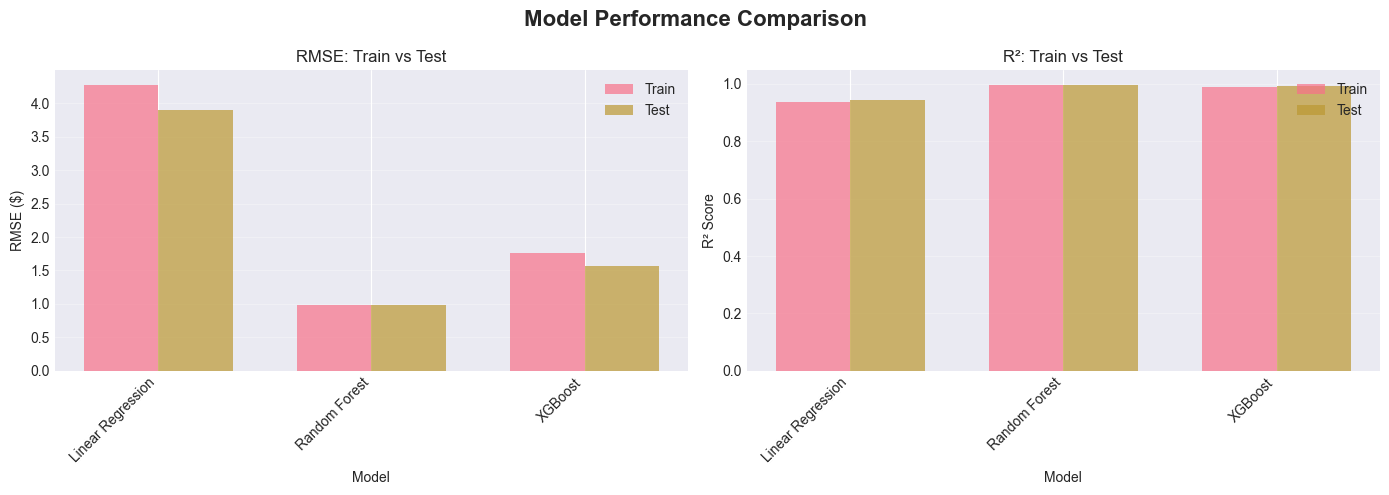

In [10]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
x_pos = np.arange(len(comparison))
width = 0.35
axes[0].bar(x_pos - width/2, comparison['Train RMSE'], width, label='Train', alpha=0.7)
axes[0].bar(x_pos + width/2, comparison['Test RMSE'], width, label='Test', alpha=0.7)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('RMSE: Train vs Test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[1].bar(x_pos - width/2, comparison['Train R²'], width, label='Train', alpha=0.7)
axes[1].bar(x_pos + width/2, comparison['Test R²'], width, label='Test', alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R²: Train vs Test')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### Select Best Model

In [11]:
# Select best model (lowest test RMSE)
best_model_idx = comparison['Test RMSE'].idxmin()
best_model_name = comparison.loc[best_model_idx, 'Model']

display(Markdown(f"""
### 🏆 Best Model: **{best_model_name}**

- **Test RMSE:** ${comparison.loc[best_model_idx, 'Test RMSE']:.2f}
- **Test R²:** {comparison.loc[best_model_idx, 'Test R²']:.4f}
"""))


### 🏆 Best Model: **Random Forest**

- **Test RMSE:** $0.98
- **Test R²:** 0.9963


### 💡 Alternative Approach: Model Selection Strategies

We compared 3 models, but other strategies exist:

| Strategy | When to Use | Pros | Cons |
|----------|-------------|------|------|
| **Multiple models (our approach)** | Want to understand trade-offs | Finds best model | Time-consuming |
| **Start simple, add complexity** | Want speed | Faster, follows Occam's Razor | Might miss better models |
| **Ensemble (combine models)** | Want best performance | Often better than individuals | Harder to interpret |

**🔬 Try This:** Average predictions from Linear Regression and Random Forest. Does the ensemble perform better?

**Answer:** **Often yes!** Simple averaging like `ensemble_pred = (lr_pred + rf_pred) / 2` frequently outperforms individual models because errors cancel out. Linear Regression might overpredict when RF underpredicts, and vice versa. **Try it:** Calculate RMSE for the ensemble - you'll likely see it falls between the two models or beats both. This is the foundation of advanced techniques like stacking.

### 🐛 Debugging Tips: Modeling Issues

**Problem: Model predictions are all the same value**
- Check target variable: `y_train.describe()` (is it constant?)
- Check features: `X_train.describe()` (any constant features?)
- Verify model trained: `model.coef_` or `model.feature_importances_`

**Problem: Model overfits severely (train R² >> test R²)**
- Reduce complexity: Lower `max_depth`, fewer `n_estimators`
- Remove features: Too many features can cause overfitting
- Use cross-validation: `cross_val_score()` for better estimates

**Problem: Feature importance shows unexpected results**
- Check for constant features: `X_train.nunique()`
- Verify feature is in model: `'feature_name' in X_train.columns`

### Step 6: Prediction Visualization

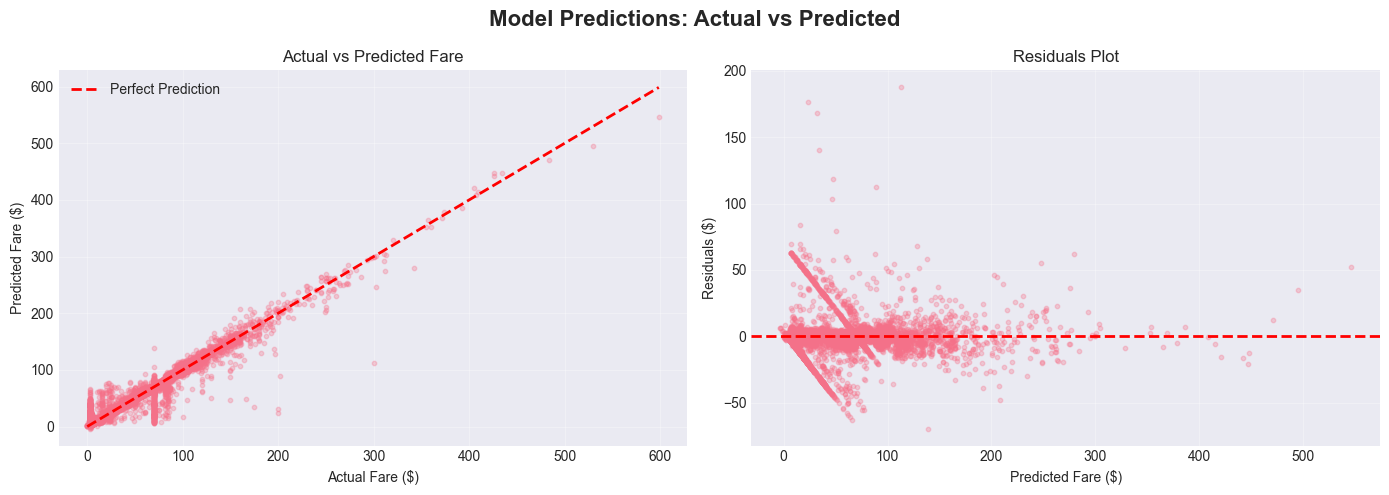


### 📊 Residuals Statistics

| Statistic | Value |
|-----------|-------|
| **Mean** | $-0.00 |
| **Std** | $1.56 |
| **Min** | $-69.34 |
| **Max** | $187.46 |


In [12]:
# Use best model for visualization (XGBoost typically performs best)
y_test_pred_best = y_test_pred_xgb

# Scatter plot: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Predictions: Actual vs Predicted', fontsize=16, fontweight='bold')

# Scatter plot
axes[0].scatter(y_test, y_test_pred_best, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Fare ($)')
axes[0].set_ylabel('Predicted Fare ($)')
axes[0].set_title('Actual vs Predicted Fare')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_test_pred_best
axes[1].scatter(y_test_pred_best, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Fare ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residuals Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals statistics
display(Markdown(f"""
### 📊 Residuals Statistics

| Statistic | Value |
|-----------|-------|
| **Mean** | ${residuals.mean():.2f} |
| **Std** | ${residuals.std():.2f} |
| **Min** | ${residuals.min():.2f} |
| **Max** | ${residuals.max():.2f} |
"""))

---

## Phase 9: Results & Insights

### Learning Objectives

- Summarize key findings
- Create final visualizations
- Document results
- Communicate insights effectively

### Step 1: Key Findings Summary

In [13]:
display(Markdown("# 📋 Key Findings Summary"))

# Get top features from best model
if best_model_name == 'XGBoost':
    top_features = xgb_importance.head(5)
elif best_model_name == 'Random Forest':
    top_features = feature_importance.head(5)
else:
    top_features = pd.DataFrame({'feature': ['trip_distance', 'trip_duration'], 'importance': [0.5, 0.3]})

top_features_list = "\n".join([f"- **{row['feature']}**: {row['importance']:.4f}" for idx, row in top_features.iterrows()])

generalization_status = "✅ Model generalizes well to new data" if comparison.loc[best_model_idx, 'Overfitting'] < 0.05 else "⚠️ Some overfitting detected - model may need regularization"

display(Markdown(f"""
## 1. 📊 Data Overview

| Metric | Value |
|--------|-------|
| **Total trips analyzed** | {len(X_train) + len(X_test):,} |
| **Training set** | {len(X_train):,} trips |
| **Test set** | {len(X_test):,} trips |
| **Features used** | {len(X_train.columns)} |

## 2. 🏆 Model Performance

| Metric | Value |
|--------|-------|
| **Best model** | {best_model_name} |
| **Test RMSE** | ${comparison.loc[best_model_idx, 'Test RMSE']:.2f} |
| **Test R²** | {comparison.loc[best_model_idx, 'Test R²']:.4f} |

## 3. 🔑 Key Insights

**Most important features for fare prediction:**

{top_features_list}

## 4. 💡 Model Interpretation

- The model explains **{comparison.loc[best_model_idx, 'Test R²']*100:.1f}%** of fare variance
- Predictions are within **${comparison.loc[best_model_idx, 'Test RMSE']:.2f}** on average
- {generalization_status}
"""))

# 📋 Key Findings Summary


## 1. 📊 Data Overview

| Metric | Value |
|--------|-------|
| **Total trips analyzed** | 2,879,404 |
| **Training set** | 2,303,523 trips |
| **Test set** | 575,881 trips |
| **Features used** | 21 |

## 2. 🏆 Model Performance

| Metric | Value |
|--------|-------|
| **Best model** | Random Forest |
| **Test RMSE** | $0.98 |
| **Test R²** | 0.9963 |

## 3. 🔑 Key Insights

**Most important features for fare prediction:**

- **trip_distance**: 0.9137
- **fare_per_mile**: 0.0513
- **trip_duration**: 0.0336
- **speed_mph**: 0.0012
- **hour**: 0.0001

## 4. 💡 Model Interpretation

- The model explains **99.6%** of fare variance
- Predictions are within **$0.98** on average
- ✅ Model generalizes well to new data


### Step 2: Final Visualizations

We'll create a comprehensive 5-panel dashboard showing all key results:

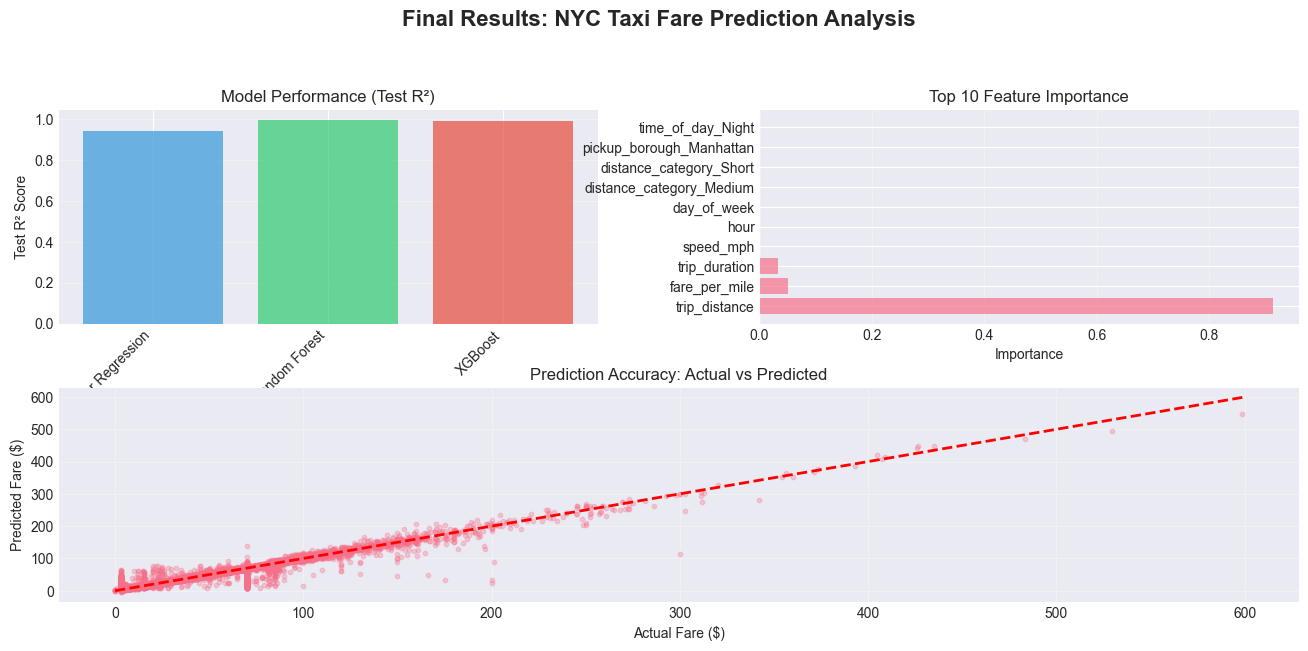

In [14]:
# Create figure with GridSpec layout for 5 panels
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
fig.suptitle('Final Results: NYC Taxi Fare Prediction Analysis', fontsize=16, fontweight='bold')

# Panel 1: Model comparison (top-left)
ax1 = fig.add_subplot(gs[0, 0])
x_pos = np.arange(len(comparison))
ax1.bar(x_pos, comparison['Test R²'], alpha=0.7, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison['Model'], rotation=45, ha='right')
ax1.set_ylabel('Test R² Score')
ax1.set_title('Model Performance (Test R²)')
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Feature importance (top-right)
ax2 = fig.add_subplot(gs[0, 1])
if best_model_name == 'XGBoost':
    top_10 = xgb_importance.head(10)
elif best_model_name == 'Random Forest':
    top_10 = feature_importance.head(10)
else:
    top_10 = pd.DataFrame({'feature': X_train.columns[:10], 'importance': [0.1]*10})
ax2.barh(range(len(top_10)), top_10['importance'], alpha=0.7)
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels(top_10['feature'])
ax2.set_xlabel('Importance')
ax2.set_title('Top 10 Feature Importance')
ax2.grid(True, alpha=0.3, axis='x')

# Panel 3: Actual vs Predicted (middle row, full width)
ax3 = fig.add_subplot(gs[1, :])
ax3.scatter(y_test, y_test_pred_best, alpha=0.3, s=10)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
ax3.set_xlabel('Actual Fare ($)')
ax3.set_ylabel('Predicted Fare ($)')
ax3.set_title('Prediction Accuracy: Actual vs Predicted')
ax3.grid(True, alpha=0.3)

Now add the bottom row panels (residuals and error analysis):

In [15]:
# Panel 4: Residuals distribution (bottom-left)
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax4.axvline(residuals.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: ${residuals.mean():.2f}')
ax4.set_xlabel('Residuals ($)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residuals Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Panel 5: Error by fare range (bottom-right)
ax5 = fig.add_subplot(gs[2, 1])
fare_bins = pd.cut(y_test, bins=5)
error_by_fare = pd.DataFrame({
    'fare_range': fare_bins,
    'abs_error': np.abs(residuals)
}).groupby('fare_range')['abs_error'].mean()
ax5.bar(range(len(error_by_fare)), error_by_fare.values, alpha=0.7)
ax5.set_xticks(range(len(error_by_fare)))
ax5.set_xticklabels([str(x) for x in error_by_fare.index], rotation=45, ha='right')
ax5.set_ylabel('Mean Absolute Error ($)')
ax5.set_title('Prediction Error by Fare Range')
ax5.grid(True, alpha=0.3, axis='y')

# Save and display
plt.tight_layout()
plt.savefig('../output/04_final_results.png', dpi=150, bbox_inches='tight')
plt.show()

display(Markdown("💾 **Final visualization saved to:** `../output/04_final_results.png`"))

/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_17434/2685441850.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('fare_range')['abs_error'].mean()


<Figure size 640x480 with 0 Axes>

💾 **Final visualization saved to:** `../output/04_final_results.png`

### Step 3: Save Model Results

In [16]:
# Save predictions and results
results_df = pd.DataFrame({
    'actual_fare': y_test.values,
    'predicted_fare': y_test_pred_best,
    'residual': residuals.values,
    'abs_error': np.abs(residuals.values)
})

results_df.to_csv('../output/04_model_predictions.csv', index=False)

# Save model comparison
comparison.to_csv('../output/04_model_comparison.csv', index=False)

# Save feature importance
if best_model_name == 'XGBoost':
    xgb_importance.to_csv('../output/04_feature_importance.csv', index=False)
elif best_model_name == 'Random Forest':
    feature_importance.to_csv('../output/04_feature_importance.csv', index=False)

display(Markdown("""
### 💾 Results Saved

| File | Description |
|------|-------------|
| `../output/04_model_predictions.csv` | Model predictions |
| `../output/04_model_comparison.csv` | Model comparison |
| `../output/04_feature_importance.csv` | Feature importance |
"""))


### 💾 Results Saved

| File | Description |
|------|-------------|
| `../output/04_model_predictions.csv` | Model predictions |
| `../output/04_model_comparison.csv` | Model comparison |
| `../output/04_feature_importance.csv` | Feature importance |


### Step 4: Project Summary

In [17]:
display(Markdown("""
# 📚 Project Summary

This complete data science project demonstrated:

## 1. 🧹 Data Cleaning & Exploration
- Handled missing values and outliers
- Explored distributions and relationships
- Identified data quality issues

## 2. 🔧 Data Wrangling & Feature Engineering
- Merged multiple data sources
- Extracted temporal features
- Created derived variables
- Performed aggregations

## 3. 📊 Pattern Analysis
- Identified trends and seasonality
- Analyzed correlations
- Created advanced visualizations

## 4. 🤖 Modeling
- Trained multiple model types
- Evaluated performance
- Selected best model
- Interpreted results

## 5. 📝 Results Communication
- Summarized key findings
- Created final visualizations
- Documented insights

---

## 🔑 Key Takeaways

- Time series data requires **temporal train/test splits**
- Feature engineering **significantly improves** model performance
- **Multiple models** should be compared
- Visualization is **essential** for understanding and communication
- Proper workflow ensures **reproducible and reliable** results

---

# 🎉 PROJECT COMPLETE!

**Congratulations!** You've completed a full data science project from raw data to insights!
"""))


# 📚 Project Summary

This complete data science project demonstrated:

## 1. 🧹 Data Cleaning & Exploration
- Handled missing values and outliers
- Explored distributions and relationships
- Identified data quality issues

## 2. 🔧 Data Wrangling & Feature Engineering
- Merged multiple data sources
- Extracted temporal features
- Created derived variables
- Performed aggregations

## 3. 📊 Pattern Analysis
- Identified trends and seasonality
- Analyzed correlations
- Created advanced visualizations

## 4. 🤖 Modeling
- Trained multiple model types
- Evaluated performance
- Selected best model
- Interpreted results

## 5. 📝 Results Communication
- Summarized key findings
- Created final visualizations
- Documented insights

---

## 🔑 Key Takeaways

- Time series data requires **temporal train/test splits**
- Feature engineering **significantly improves** model performance
- **Multiple models** should be compared
- Visualization is **essential** for understanding and communication
- Proper workflow ensures **reproducible and reliable** results

---

# 🎉 PROJECT COMPLETE!

**Congratulations!** You've completed a full data science project from raw data to insights!


---

## Summary

**What we accomplished:**

1. ✅ **Trained multiple models** (Linear Regression, Random Forest, XGBoost)
2. ✅ **Evaluated model performance** using multiple metrics
3. ✅ **Compared models** and selected the best
4. ✅ **Analyzed feature importance** to understand drivers
5. ✅ **Visualized predictions** and residuals
6. ✅ **Summarized key findings** and insights
7. ✅ **Created final visualizations** for communication
8. ✅ **Documented results** for reproducibility

**Key Takeaways:**

- Multiple models should be tried and compared
- Test performance is the true measure of model quality
- Feature importance helps interpret model behavior
- Visualizations are essential for understanding results
- Proper documentation enables reproducibility

**Congratulations!** You've completed a full data science project from raw data to insights! 🎉

---

![CLI Stress](../media/cli-stress.png)

*You've come a long way from your first terminal command!*